# Compute mean daily cycle of precipitation for all seasons

In [1]:
import xarray as xr
import dask

url = "/pool/data/CORDEX/data/cordex/output/EUR-22/GERICS/ECMWF-ERAINT/evaluation/r1i1p1/GERICS-REMO2015/v1/1hr/pr/v20191030/*"

In [2]:
from dask.distributed import Client

client = Client()
client

/work/ch0636/g300046/conda_envs/pyremo-dev/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38745 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/g300046/levante-spawner-preset//proxy/38745/status,
Dashboard: /user/g300046/levante-spawner-preset//proxy/38745/status,Workers: 9
Total threads: 54,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44495,Workers: 9
Dashboard: /user/g300046/levante-spawner-preset//proxy/38745/status,Total threads: 54
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:46245,Total threads: 6
Dashboard: /user/g300046/levante-spawner-preset//proxy/40801/status,Memory: 11.11 GiB
Nanny: tcp://127.0.0.1:43507,


In [3]:
ds = xr.open_mfdataset(url, use_cftime=True, coords="minimal", data_vars="minimal")
ds

<xarray.Dataset>
Dimensions:                     (time: 341880, bnds: 2, rlat: 201, rlon: 225,
                                 vertices: 4)
Coordinates:
  * time                        (time) object 1979-01-01 01:00:00 ... 2018-01...
  * rlat                        (rlat) float64 -22.88 -22.66 ... 20.9 21.12
  * rlon                        (rlon) float64 -29.86 -29.64 ... 19.2 19.42
    lat                         (rlat, rlon) float32 dask.array<chunksize=(201, 225), meta=np.ndarray>
    lon                         (rlat, rlon) float32 dask.array<chunksize=(201, 225), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds                   (time, bnds) object dask.array<chunksize=(8760, 2), meta=np.ndarray>
    rotated_latitude_longitude  int32 -2147483647
    lat_vertices                (rlat, rlon, vertices) float32 dask.array<chunksize=(201, 225, 4), meta=np.ndarray>
    lon_vertices                (rlat, rlon, vertices) float32 dask.array<chunksize=(201, 225, 4), meta=np.ndarray>
    pr                          (time, rlat, rlon) float32 dask.array<chunksize=(8760, 201, 225), meta=np.ndarray>
Attributes: (12/34)
    institution:                    Helmholtz-Zentrum Geesthacht, Climate Ser...
    institute_id:                   GERICS
    experiment_id:                  evaluation
    source:                         GERICS-REMO2015
    model_id:                       GERICS-REMO2015
    forcing:                        N/A
    ...                             ...
    title:                          GERICS-REMO2015 model output prepared for...
    parent_experiment:              N/A
    modeling_realm:                 atmos
    realization:                    1
    cmor_version:                   2.9.1
    tracking_id:                    hdl:21.14103/e14fcf58-0c9a-453f-aaab-347d...

In [4]:
with dask.config.set(**{"array.slicing.split_large_chunks": True}):
    summer = ds.groupby("time.season")["JJA"]
summer

<xarray.Dataset>
Dimensions:                     (time: 86112, bnds: 2, rlat: 201, rlon: 225,
                                 vertices: 4)
Coordinates:
  * time                        (time) object 1979-06-01 00:00:00 ... 2017-08...
  * rlat                        (rlat) float64 -22.88 -22.66 ... 20.9 21.12
  * rlon                        (rlon) float64 -29.86 -29.64 ... 19.2 19.42
    lat                         (rlat, rlon) float32 dask.array<chunksize=(201, 225), meta=np.ndarray>
    lon                         (rlat, rlon) float32 dask.array<chunksize=(201, 225), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds                   (time, bnds) object dask.array<chunksize=(2208, 2), meta=np.ndarray>
    rotated_latitude_longitude  int32 -2147483647
    lat_vertices                (rlat, rlon, vertices) float32 dask.array<chunksize=(201, 225, 4), meta=np.ndarray>
    lon_vertices                (rlat, rlon, vertices) float32 dask.array<chunksize=(201, 225, 4), meta=np.ndarray>
    pr                          (time, rlat, rlon) float32 dask.array<chunksize=(736, 201, 225), meta=np.ndarray>
Attributes: (12/34)
    institution:                    Helmholtz-Zentrum Geesthacht, Climate Ser...
    institute_id:                   GERICS
    experiment_id:                  evaluation
    source:                         GERICS-REMO2015
    model_id:                       GERICS-REMO2015
    forcing:                        N/A
    ...                             ...
    title:                          GERICS-REMO2015 model output prepared for...
    parent_experiment:              N/A
    modeling_realm:                 atmos
    realization:                    1
    cmor_version:                   2.9.1
    tracking_id:                    hdl:21.14103/e14fcf58-0c9a-453f-aaab-347d...

In [5]:
mean = summer.groupby("time.hour").mean(method="map-reduce", engine="flox")
%time mean_ = mean.pr.compute()

CPU times: user 7.03 s, sys: 864 ms, total: 7.9 s
Wall time: 1min 22s


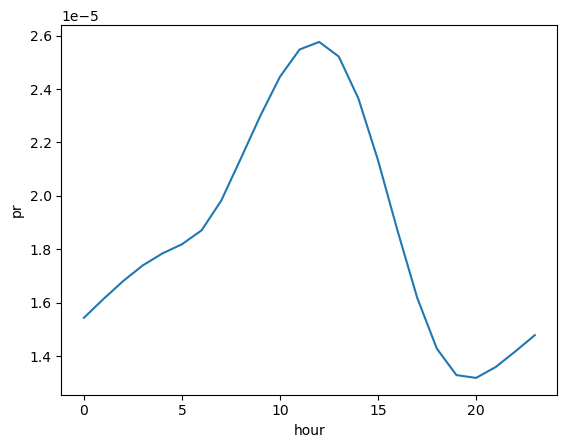

In [7]:
mean_.mean(("rlon", "rlat")).plot()

In [8]:
def hourly_mean(ds):
    return ds.groupby("time.hour").mean()


with dask.config.set(**{"array.slicing.split_large_chunks": True}):
    means = ds.groupby("time.season").apply(hourly_mean)
means

<xarray.Dataset>
Dimensions:                     (season: 4, hour: 24, rlat: 201, rlon: 225,
                                 vertices: 4)
Coordinates:
  * rlat                        (rlat) float64 -22.88 -22.66 ... 20.9 21.12
  * rlon                        (rlon) float64 -29.86 -29.64 ... 19.2 19.42
    lon                         (rlat, rlon) float32 dask.array<chunksize=(201, 225), meta=np.ndarray>
    lat                         (rlat, rlon) float32 dask.array<chunksize=(201, 225), meta=np.ndarray>
  * hour                        (hour) int64 0 1 2 3 4 5 6 ... 18 19 20 21 22 23
  * season                      (season) object 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: vertices
Data variables:
    pr                          (season, hour, rlat, rlon) float32 dask.array<chunksize=(1, 24, 201, 225), meta=np.ndarray>
    rotated_latitude_longitude  (season, hour) int32 -2147483647 ... -2147483647
    lat_vertices                (season, hour, rlat, rlon, vertices) float32 dask.array<chunksize=(1, 24, 201, 225, 4), meta=np.ndarray>
    lon_vertices                (season, hour, rlat, rlon, vertices) float32 dask.array<chunksize=(1, 24, 201, 225, 4), meta=np.ndarray>
Attributes: (12/34)
    institution:                    Helmholtz-Zentrum Geesthacht, Climate Ser...
    institute_id:                   GERICS
    experiment_id:                  evaluation
    source:                         GERICS-REMO2015
    model_id:                       GERICS-REMO2015
    forcing:                        N/A
    ...                             ...
    title:                          GERICS-REMO2015 model output prepared for...
    parent_experiment:              N/A
    modeling_realm:                 atmos
    realization:                    1
    cmor_version:                   2.9.1
    tracking_id:                    hdl:21.14103/e14fcf58-0c9a-453f-aaab-347d...

In [9]:
%time means_ = means.compute()

CPU times: user 22.1 s, sys: 2.43 s, total: 24.5 s
Wall time: 1min 43s


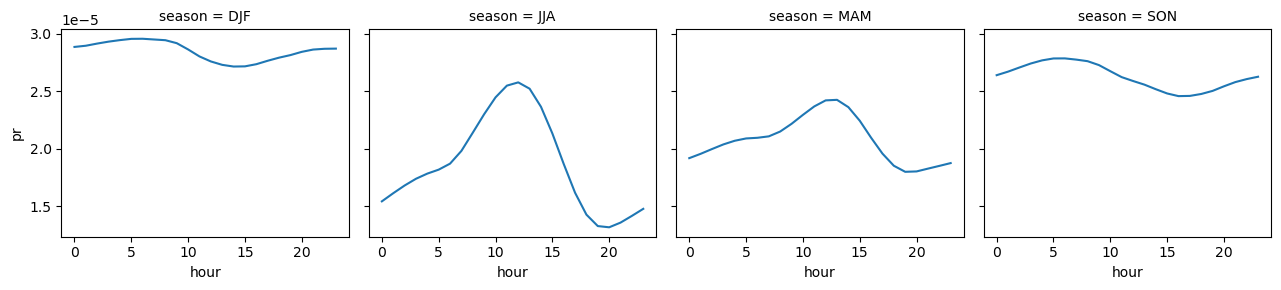

In [10]:
means_.pr.mean(("rlon", "rlat")).plot(col="season")